# Import

In [1]:
!nvidia-smi

Wed Jan  6 01:34:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    On   | 00000000:01:00.0 Off |                  N/A |
|  0%   51C    P5    57W / 350W |    286MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
import pandas as pd
import numpy as np
import glob
#import cupy as cp
import os
import gc
import time
import torch
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
print(torch.__version__)
import matplotlib.pyplot as plt
from numba import njit
%matplotlib inline
from janest_model import MLPNet , CustomDataset, train_model
from utils import PurgedGroupTimeSeriesSplit

1.7.1+cu110


In [ ]:
#%%writefile test.py
#print('hello world!')

## Parameter setting

In [3]:
TRAINING = True
USE_FINETUNE = True     
FOLDS = 5
GROUP_GAP = 20
SEED = 66
INPUTPATH = '../../input'
NUM_EPOCH = 500
BATCH_SIZE = 16384
PATIANCE = 15
LR = 0.0005
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
MDL_PATH  = '../models'
MDL_NAME = 'mlp'
NUM_LYR = 5
VER = 'cv_base'

cuda


## Import Data 

In [4]:
%%time
train = pd.read_parquet(f'{INPUTPATH}/train.parquet')
test_df = pd.read_csv(f'{INPUTPATH}/example_test.csv')
pred_df  = pd.read_csv(f'{INPUTPATH}/example_sample_submission.csv')

CPU times: user 8.3 s, sys: 3.87 s, total: 12.2 s
Wall time: 1.25 s


In [ ]:
test_df.head()

In [ ]:
train.head()

# Features

In [5]:
%%time
train = train.query('date > 85').reset_index(drop = True) 
print(train.shape)
train.fillna(train.mean(),inplace=True)
train = train.query('weight > 0').reset_index(drop = True)
train['action'] =  \
(  (train['resp_1'] > 0.00001 ) & \
   (train['resp_2'] > 0.00001 ) & \
   (train['resp_3'] > 0.00001 ) & \
   (train['resp_4'] > 0.00001 ) & \
   (train['resp'] > 0.00001 )   ).astype('int')

features = [c for c in train.columns if 'feature' in c]

resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']

X = train[features].values
y = np.stack([(train[c] > 0.000001).astype('int') for c in resp_cols]).T
#X = cp.array(train[features].values)
#y = cp.array(np.stack([(train[c] > 0.000001).astype('int') for c in resp_cols]).T) #Multitarget
#f_mean = np.mean(train[features[1:]].values,axis=0)

f_mean = np.load( f'{INPUTPATH}/f_mean.npy')

(1571415, 139)
CPU times: user 1.76 s, sys: 730 ms, total: 2.49 s
Wall time: 2.48 s


In [ ]:
#%%time
#np.save( f'{INPUTPATH}/f_mean.npy',f_mean)

In [ ]:
print(X.shape[-1])
print(y.shape[-1])

# Trainning

## Data Split

In [6]:
gkf =  PurgedGroupTimeSeriesSplit(n_splits = FOLDS,  group_gap = GROUP_GAP)

## MLP

### CV 

In [24]:
model

MLPNet(
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (bat): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): Sigmoid()
  (encoder): Sequential(
    (0): BatchNorm1d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=130, out_features=512, bias=True)
    (2): ReLU(inplace=True)
  )
  (layer): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Hardswish()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Hardswish()
    (7): Dropout(p=0.5, inplace=False)
  )
)

In [7]:
model = MLPNet(input_size = X.shape[-1], output_size = y.shape[-1]).to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min',verbose=True,patience=5)

Fold : 1


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500],        Train BCE loss: 0.712545,         Valid BCE loss: 0.692359,       Early stopping counter: 0
Epoch [2/500],        Train BCE loss: 0.701107,         Valid BCE loss: 0.691697,       Early stopping counter: 0
Epoch [3/500],        Train BCE loss: 0.696856,         Valid BCE loss: 0.691141,       Early stopping counter: 0
Epoch [4/500],        Train BCE loss: 0.693769,         Valid BCE loss: 0.690901,       Early stopping counter: 0
Epoch [5/500],        Train BCE loss: 0.692561,         Valid BCE loss: 0.690779,       Early stopping counter: 0
Epoch [6/500],        Train BCE loss: 0.691363,         Valid BCE loss: 0.690632,       Early stopping counter: 0
Epoch [7/500],        Train BCE loss: 0.690843,         Valid BCE loss: 0.690521,       Early stopping counter: 0
Epoch [8/500],        Train BCE loss: 0.690343,         Valid BCE loss: 0.690427,       Early stopping counter: 0
Epoch [9/500],        Train BCE loss: 0.689865,         Valid BCE loss: 0.690346,       

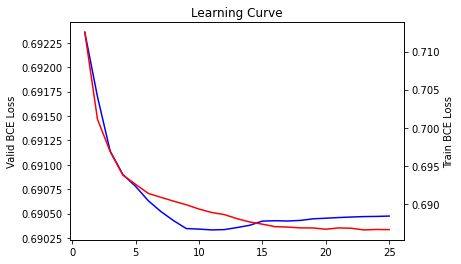

Fold : 2


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch    27: reducing learning rate of group 0 to 5.0000e-07.
Epoch [1/500],        Train BCE loss: 0.690688,         Valid BCE loss: 0.690967,       Early stopping counter: 0
Epoch [2/500],        Train BCE loss: 0.690954,         Valid BCE loss: 0.690963,       Early stopping counter: 0
Epoch [3/500],        Train BCE loss: 0.690867,         Valid BCE loss: 0.690954,       Early stopping counter: 0
Epoch [4/500],        Train BCE loss: 0.690747,         Valid BCE loss: 0.690938,       Early stopping counter: 0
Epoch [5/500],        Train BCE loss: 0.690829,         Valid BCE loss: 0.690923,       Early stopping counter: 0
Epoch [6/500],        Train BCE loss: 0.690737,         Valid BCE loss: 0.690919,       Early stopping counter: 0
Epoch    33: reducing learning rate of group 0 to 5.0000e-08.
Epoch [7/500],        Train BCE loss: 0.690787,         Valid BCE loss: 0.690911,       Early stopping counter: 0
Epoch [8/500],        Train BCE loss: 0.690849,         Valid BCE loss: 0.6909

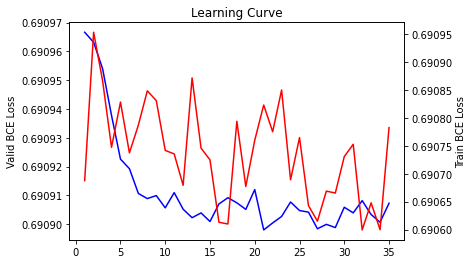

Fold : 3


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500],        Train BCE loss: 0.691827,         Valid BCE loss: 0.690320,       Early stopping counter: 0
Epoch [2/500],        Train BCE loss: 0.691696,         Valid BCE loss: 0.690330,       Early stopping counter: 1
Epoch [3/500],        Train BCE loss: 0.691665,         Valid BCE loss: 0.690330,       Early stopping counter: 2
Epoch [4/500],        Train BCE loss: 0.691726,         Valid BCE loss: 0.690325,       Early stopping counter: 3
Epoch [5/500],        Train BCE loss: 0.691706,         Valid BCE loss: 0.690330,       Early stopping counter: 4
Epoch [6/500],        Train BCE loss: 0.691629,         Valid BCE loss: 0.690325,       Early stopping counter: 5
Epoch [7/500],        Train BCE loss: 0.691698,         Valid BCE loss: 0.690327,       Early stopping counter: 6
Epoch [8/500],        Train BCE loss: 0.691774,         Valid BCE loss: 0.690328,       Early stopping counter: 7
Epoch [9/500],        Train BCE loss: 0.691608,         Valid BCE loss: 0.690328,       

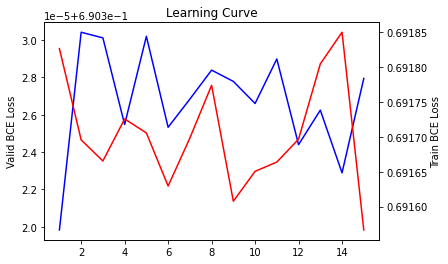

Fold : 4


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500],        Train BCE loss: 0.692212,         Valid BCE loss: 0.691620,       Early stopping counter: 0
Epoch [2/500],        Train BCE loss: 0.692196,         Valid BCE loss: 0.691636,       Early stopping counter: 1
Epoch [3/500],        Train BCE loss: 0.692151,         Valid BCE loss: 0.691619,       Early stopping counter: 0
Epoch [4/500],        Train BCE loss: 0.692225,         Valid BCE loss: 0.691618,       Early stopping counter: 0
Epoch [5/500],        Train BCE loss: 0.692275,         Valid BCE loss: 0.691624,       Early stopping counter: 1
Epoch [6/500],        Train BCE loss: 0.692225,         Valid BCE loss: 0.691621,       Early stopping counter: 2
Epoch [7/500],        Train BCE loss: 0.692172,         Valid BCE loss: 0.691624,       Early stopping counter: 3
Epoch [8/500],        Train BCE loss: 0.692181,         Valid BCE loss: 0.691625,       Early stopping counter: 4
Epoch [9/500],        Train BCE loss: 0.692242,         Valid BCE loss: 0.691626,       

Epoch [73/500],        Train BCE loss: 0.692116,         Valid BCE loss: 0.691603,       Early stopping counter: 1
Epoch [74/500],        Train BCE loss: 0.692256,         Valid BCE loss: 0.691605,       Early stopping counter: 2
Epoch [75/500],        Train BCE loss: 0.692277,         Valid BCE loss: 0.691598,       Early stopping counter: 3
Epoch [76/500],        Train BCE loss: 0.692225,         Valid BCE loss: 0.691602,       Early stopping counter: 4
Epoch [77/500],        Train BCE loss: 0.692272,         Valid BCE loss: 0.691604,       Early stopping counter: 5
Epoch [78/500],        Train BCE loss: 0.692062,         Valid BCE loss: 0.691597,       Early stopping counter: 6
Epoch [79/500],        Train BCE loss: 0.692143,         Valid BCE loss: 0.691598,       Early stopping counter: 7
Epoch [80/500],        Train BCE loss: 0.692229,         Valid BCE loss: 0.691598,       Early stopping counter: 8
Epoch [81/500],        Train BCE loss: 0.692151,         Valid BCE loss: 0.69159

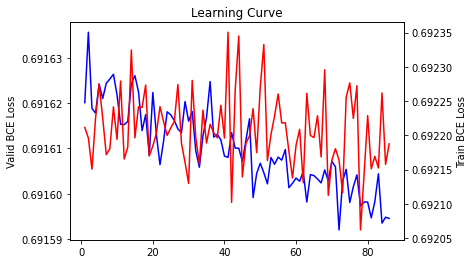

Fold : 5


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500],        Train BCE loss: 0.692505,         Valid BCE loss: 0.690686,       Early stopping counter: 0
Epoch [2/500],        Train BCE loss: 0.692594,         Valid BCE loss: 0.690687,       Early stopping counter: 1
Epoch [3/500],        Train BCE loss: 0.692511,         Valid BCE loss: 0.690687,       Early stopping counter: 2
Epoch [4/500],        Train BCE loss: 0.692507,         Valid BCE loss: 0.690682,       Early stopping counter: 0
Epoch [5/500],        Train BCE loss: 0.692464,         Valid BCE loss: 0.690691,       Early stopping counter: 1
Epoch [6/500],        Train BCE loss: 0.692462,         Valid BCE loss: 0.690682,       Early stopping counter: 0
Epoch [7/500],        Train BCE loss: 0.692515,         Valid BCE loss: 0.690682,       Early stopping counter: 0
Epoch [8/500],        Train BCE loss: 0.692500,         Valid BCE loss: 0.690687,       Early stopping counter: 1
Epoch [9/500],        Train BCE loss: 0.692530,         Valid BCE loss: 0.690684,       

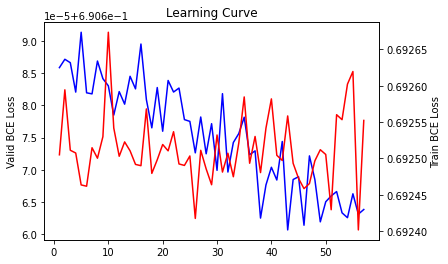

Training process takes 63.18 min.


In [8]:
sts = time.time()
learn_hist_list = []
save_path_list = []
for fold, (tr, vl) in enumerate(gkf.split(train['action'].values, train['action'].values, train['date'].values)):
    print('Fold : {}'.format(fold+1))
    
    X_tr, X_val = X[tr], X[vl]
    y_tr, y_val = y[tr], y[vl]
    trn_dat = CustomDataset(X_tr, y_tr)
    val_dat = CustomDataset(X_val, y_val)
    trn_loader = DataLoader(trn_dat , batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dat , batch_size=BATCH_SIZE, shuffle=False)
    loaders = {'train':trn_loader, 'valid': val_loader}
    trained_model, learn_hist, save_path =\
        train_model(model, criterion, optimizer, scheduler, loaders, DEVICE, NUM_EPOCH, PATIANCE, \
                MDL_PATH, MDL_NAME, VER, fold+1)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.plot(learn_hist.epoch, learn_hist.valid_bce_loss, color = 'blue')
    ax2 = ax1.twinx()
    plt.plot(learn_hist.epoch, learn_hist.train_bce_loss, color = 'red')
    ax1.set_ylabel('Valid BCE Loss')
    ax2.set_ylabel('Train BCE Loss')
    plt.xlabel('Epochs')
    plt.title('Learning Curve')
    plt.show()
    learn_hist['Fold'] = fold+1
    learn_hist_list.append(learn_hist)
    save_path_list.append(save_path)
all_hist = pd.concat(learn_hist_list, axis=0)
all_hist.reset_index(inplace=True, drop=True)
all_hist.to_csv(f'{MDL_PATH}/{MDL_NAME}_{VER}/{MDL_NAME}_learning_history.csv', index=False)
ed = time.time()
print('Training process takes {:.2f} min.'.format((ed-sts)/60))

In [9]:
@njit(fastmath = True)
def utility_score_numba(date, weight, resp, action):
    Pi = np.bincount(date, weight * resp * action)
    t = np.sum(Pi) / np.sqrt(np.sum(Pi ** 2)) * np.sqrt(250 / len(Pi))
    u = min(max(t, 0), 6) * np.sum(Pi)
    return u

#https://www.kaggle.com/gogo827jz/jane-street-super-fast-utility-score-function

In [26]:
model_list  = glob.glob(f'{MDL_PATH}/{MDL_NAME}_{VER}/*.pth')

In [27]:
torch.cuda.empty_cache()

In [28]:
th = 0.5
loop = int(np.round(len(X)/BATCH_SIZE))
pred_all = np.array([])
for n in tqdm(range(loop)):
    x_tt = X[BATCH_SIZE*n:BATCH_SIZE*(n+1),:]
    if np.isnan(x_tt[:, 1:].sum()):
        x_tt[:, 1:] = np.nan_to_num(x_tt[:, 1:]) + np.isnan(x_tt[:, 1:]) * f_mean
    pred = 0.0
    X_test = torch.FloatTensor(x_tt).to(DEVICE)
    for mdl in model_list:
        load_weights = torch.load(mdl)
        model.load_state_dict(load_weights)
        model.eval()
        pred += model(X_test).cpu().detach().numpy() / FOLDS
    if len(pred_all) == 0:
        pred_all = pred.copy()
    else:
        pred_all = np.vstack([pred_all, pred]).copy()

  0%|          | 0/96 [00:00<?, ?it/s]

In [30]:
date = train['date'].values
weight = train['weight'].values
resp = train['resp'].values
train['action'] = (train['resp'] > 0).astype('int')
action_ans = train['action'].values

In [47]:
th=0.511
action = np.where(pred_all[:,0] >= th, 1, 0).astype(int).copy()
utility_score_numba(date, weight, resp, action)

4802.998051218225

In [32]:
utility_score_numba(date, weight, resp, action_ans)

173797.76047460194

In [48]:
gc.collect()

14341

## Predict Test 

In [ ]:
print(f'{MDL_PATH}/{MDL_NAME}_{VER}')

In [ ]:
#!kaggle datasets init -p ../models/autoencoder_test

In [ ]:
%%writefile ../models/mlp_base/dataset-metadata.json
{
    "title": "Jane-Street",
    "id": "shinsei66/Jane-Street",
    "subtitle": "",
    "description": "",
    "isPrivate": true,
    "licenses": [
        {
            "name": "unknown" 
        }
    ],
    "keywords": [],
    "collaborators": [],
    "data": [
        {
            "description": null,
            "name": "autoencoder_99.pth",
            "totalBytes": 848,
            "columns": []
        },
        {
            "description": null,
            "name": "autoencoder_254.pth",
            "totalBytes": 856,
            "columns": []
        },
        {
            "description": null,
            "name": "mlp_base_984.pth",
            "totalBytes": 1316,
            "columns": []
        }
    ]
}

In [ ]:
#!kaggle datasets create -p  ../models/autoencoder_early_stopping

In [ ]:
!du ../models/mlp_base/mlp_984.pth

In [ ]:
!kaggle datasets version -p  ../models/mlp_base -m "mlp base 984 epoch"